XG Boost
=======

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,\
                            precision_recall_fscore_support, auc, accuracy_score

from bayes_opt import BayesianOptimization

In [2]:
data = pd.read_csv("../data/loans_sample_processed.csv", sep = "^").sample(100000, random_state = 4290)

In [3]:
data.head()

,funded_amnt_inv,installment,int_rate,annual_inc,dti,total_rec_late_fee,total_acc,manager,refinance,term_ 36 months,...,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,application_type_Individual,application_type_Joint App,non_payment
337231,15000.0,555.32,19.72,55000.00,15.77,0.0,47.0,0,1,1,...,0,0,0,0,0,0,1,1,0,0
556157,15400.0,515.12,12.49,110000.00,10.19,0.0,26.0,0,1,1,...,0,0,0,0,0,0,1,1,0,0
580514,15000.0,501.74,12.49,44275.82,13.93,0.0,17.0,0,1,1,...,0,0,0,0,0,0,1,1,0,1
446532,12000.0,377.09,8.19,69000.00,19.63,0.0,19.0,0,1,1,...,0,0,0,0,0,0,1,1,0,0
95642,2300.0,78.60,13.99,30000.00,18.68,0.0,11.0,1,1,1,...,0,0,0,0,0,0,1,1,0,0


In [4]:
data.shape

(100000, 38)

__Train / Test split:__

In [5]:
X = data.loc[:, data.columns!='non_payment']

In [6]:
y = data['non_payment']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4290)

In [8]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

__Prior__:

In [9]:
y.value_counts()[0] / len(y)

0.79388

__XG Boost__ with Bayesian Optimization:

Parameters for optimization:

In [10]:
xg_params_bay = {'colsample_bytree': (0.4, 1.0),
                 'max_depth': (2, 15),
                 'subsample': (0.4, 1.0),
                 'n_estimators': (10, 1500),
                 'learning_rate': (0.001, 0.3)}

XG Boost evaluate function for Bayesian optimization:

In [11]:
def xgb_evaluate(colsample_bytree, max_depth, subsample, n_estimators, learning_rate):
    
    # params:
    params = {'colsample_bytree': colsample_bytree,
              'max_depth': int(max_depth),
              'subsample': subsample,
              'n_estimators': int(n_estimators),
              'learning_rate': learning_rate}
    
    # gradient boosting model
    gbm = xgb.XGBClassifier(colsample_bytree=params['colsample_bytree'], 
                            max_depth=params['max_depth'], 
                            subsample=params['subsample'], 
                            n_estimators=params['n_estimators'],
                            learning_rate=params['learning_rate'])
    
    gbm.fit(X_train, y_train)
    
    # scores in the test set
    y_scores_test = gbm.predict_proba(X_test)
    y_scores_test = pd.DataFrame(y_scores_test).loc[:,1]
    
    
    # metric to optimize
    metric = roc_auc_score(y_test, y_scores_test)
    
    return metric

Bayesian Optimization:

In [12]:
bay_optimization = BayesianOptimization(xgb_evaluate, xg_params_bay)

In [13]:
bay_optimization.maximize()

Initialization
-----------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   n_estimators |   subsample | 
{'colsample_bytree': 0.8680632737860082, 'max_depth': 4, 'subsample': 0.8941577540724481, 'n_estimators': 1260, 'learning_rate': 0.14513031880474364}
    1 | 04m16s |    0.71082 |             0.8681 |          0.1451 |      4.2849 |      1260.9191 |      0.8942 | 
{'colsample_bytree': 0.522939313984844, 'max_depth': 12, 'subsample': 0.4060215610149257, 'n_estimators': 98, 'learning_rate': 0.1865051063997713}
    2 | 00m48s |    0.68019 |             0.5229 |          0.1865 |     12.4960 |        98.6424 |      0.4060 | 
{'colsample_bytree': 0.8208910527930338, 'max_depth': 10, 'subsample': 0.4581686745818149, 'n_estimators': 125, 'learning_rate': 0.07142120722387724}
    3 | 01m16s |    0.71342 |             0.8209 |          0.0714 |     10.194

In [14]:
gbm = xgb.XGBClassifier(colsample_bytree=0.6, 
                            max_depth=2, 
                            subsample=0.9, 
                            n_estimators=500,
                            learning_rate=0.3)

In [15]:
gbm.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

__Model Evaluation__

AUC in the train set:

In [16]:
y_scores_train = gbm.predict_proba(X_train)

y_scores_train = pd.DataFrame(y_scores_train).loc[:,1]

In [17]:
roc_auc_score(y_train, y_scores_train)

0.7511083002726155

ROC Curve:

In [19]:
y_scores = gbm.predict_proba(X_test)

y_scores = pd.DataFrame(y_scores).loc[:,1]

In [20]:
fpr, tpr, _ = roc_curve(y_test, y_scores)

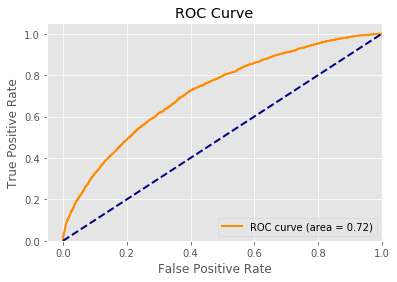

In [21]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

AUC:

In [22]:
roc_auc_score(y_test, y_scores)

0.7204332943382775

In [26]:
confusion_matrix(y_test, y_predictions)

array([[15461,   383],
       [ 3592,   564]])

Accuracy:

In [27]:
accuracy_score(y_test, y_predictions)

0.80125

Recall:

In [28]:
precision_recall_fscore_support(y_test, y_predictions) [0]

array([0.81147326, 0.59556494])

Precision:

In [29]:
precision_recall_fscore_support(y_test, y_predictions) [1]

array([0.97582681, 0.13570741])

__Output__:

In [32]:
y_scores_train.to_csv("../output/y_scores_train_xg.csv", sep = "^", index = False)
y_scores.to_csv("../output/y_scores_test_xg.csv", sep = "^", index = False)